In [7]:
!pip install opencv-python
!pip install tensorflow

  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-23.1.21-py2.py3-none-any.whl (26 kB)
  Using cached termcolor-2.2.0-py3-none-any.whl (6.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached libclang-15.0.6.1-py2.py3-none-win_amd64.whl (23.2 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
# 데이터셋 불러오기

TRAIN_DATASET = sorted([x for x in Path("D:\\AI\\data\\dataset\\HAI 2.0\\training").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("D:\\AI\\data\\dataset\\HAI 2.0\\testing").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("D:\\AI\\data\\dataset\\HAI 2.0\\validation").glob("*.csv")])


In [10]:
def dataframe_from_csv(target):
    return pd.read_csv(target,engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)

TIMESTAMP_FIELD = 'time'
IDSTAMP_FIELD ='id'
ATTACK_FIELD = 'attack'
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [11]:
# 데이터 정규화
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c]- TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

def boundary_check(df):
    x = np.array(df, dtype= np.float32)
    print(x)
    return np.any(x >1.0),np.any(x <0), np.any(np.isnan(x))

boundary_check(TRAIN_DF)

def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps -1):
        t= []
        for j in range(1, timesteps +1):
            t.append(X[[i + j + 1], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

[[0.37895253 0.         0.         ... 0.2650172  1.         0.5672542 ]
 [0.37845883 0.         0.         ... 0.2504694  1.         0.5066231 ]
 [0.37845883 0.         0.         ... 0.25502798 1.         0.46494597]
 ...
 [0.30434805 0.         0.         ... 0.23551878 0.26161984 0.625875  ]
 [0.3068182  0.         0.         ... 0.26957628 0.26161984 0.6820907 ]
 [0.30484188 0.         0.         ... 0.29337597 0.26161984 0.7588398 ]]


(921603, 1, 79)

In [12]:
#모델 = keras
def temporalize(X, y, timesteps):
    output_X =[]
    output_y =[]
    for i in range(len(X) - timesteps - 1):
        t =[]
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)
# reshape = 3차원 배열로 만들어줌 
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape                            

(921603, 1, 79)

In [13]:
# 모델 
#################################
# parameter (Conv1D) 
# filters : 컨볼루션 연산의 output 출력 수 
# kernel_size : timestamp를 얼마만큼 볼 것인가 (=window_size)
# padding : 한 쪽 방향으로 얼마만큼 padding 할 것인가 
# dilation: kernel 내부에서 얼마만큼의 간격으로 kernel을 적용할 것인가
# stride : default =1, 컨볼루션 레이어의 이동 크기 

#################################
# LSTM
# unit: 출력 차원층만 설정

In [14]:
# 모델 생성
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]
    
    keras.backend.clear_session()
    
    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding="same", data_format='channels_last',
                        dilation_rate =1, activation= "linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units= 64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same',data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation="linear"))
        ]
    )
    return model
model= conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            2589184   
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

In [15]:
# 모델 학습하기 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
epochs = 3
batch =64
# fit 
history = model.fit(x_train, x_train,
                    epochs=epochs, batch_size=batch,
                    validation_split=0.2, callbacks=[early_stopping]).history

model.save('model.h5')

Epoch 1/3
11521/11521 [==============================] - 4077s 354ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 2/3
11521/11521 [==============================] - 4087s 355ms/step - loss: 1.6112e-04 - val_loss: 2.1187e-04
Epoch 3/3
11521/11521 [==============================] - 4439s 385ms/step - loss: 1.0201e-04 - val_loss: 1.3339e-04


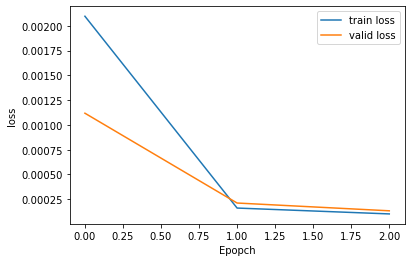

In [16]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epopch');plt.ylabel('loss')
plt.show()

In [18]:
model = load_model('model.h5')

In [20]:
# 학습된 모델을 검증 데이터셋에 적용하여 이상 탐지
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [22]:
VALIDATION_DF= normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
boundary_check(VALIDATION_DF)

[[0.45158097 0.         0.         ... 0.5797802  0.52712005 0.4013713 ]
 [0.45256948 0.         0.         ... 0.5799144  0.52712005 0.32340166]
 [0.45207536 0.         0.         ... 0.5926521  0.52712005 0.37272498]
 ...
 [0.39772758 0.         0.         ... 0.6184636  0.17970447 0.23875508]
 [0.3997038  0.         0.         ... 0.62228477 0.17970447 0.129734  ]
 [0.401186   0.         0.         ... 0.62047464 0.17970447 0.02301037]]


(True, True, False)

<AxesSubplot:>

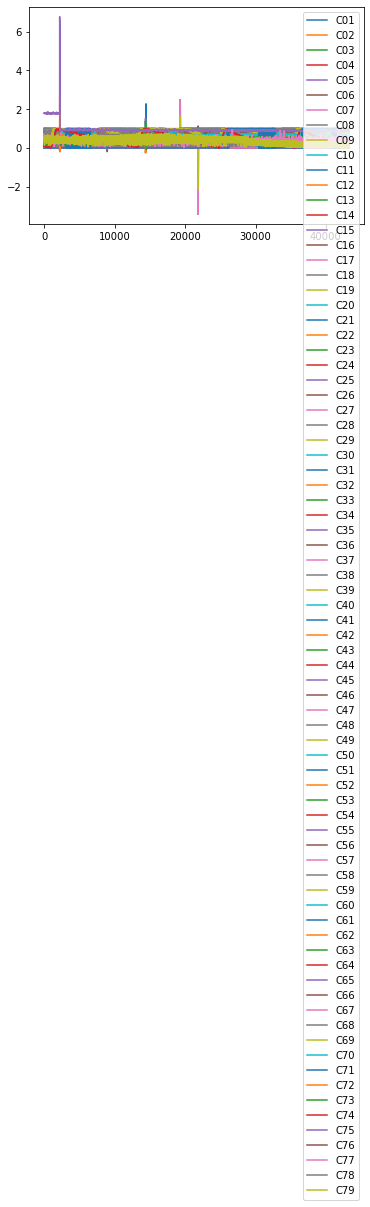

In [23]:
VALIDATION_DF.plot()

<AxesSubplot:>

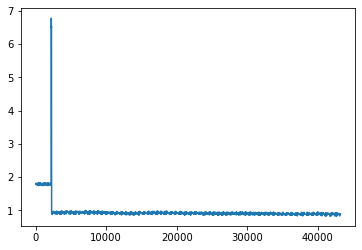

In [24]:
VALIDATION_DF['C75'].plot()

In [26]:
# 데이터 cleaning , valid 그래프를 보고 앞부분 정상인데 값이 튀는 변수가 있어서 조절
VALIDATION_DF['C75'][:2110] = 0.95

In [27]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(43201, 1, 79)

In [34]:
# flatten() 함수를 이용한 2차원으로 변경하는 함수 
# flatten() : 다차원을 1차원으로 변경해주는 내장함수 
# 모델의 결과가 3차원이기 때문에 복원된 결과와의 차이를 확인하기 위해 2차원으로 변경해줌
# empty : 배열을 생성해줌 

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i,(X.shape[1]-1),:]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i,:,:])
    return X 


In [35]:
# 모델에 의해 재구성된 값을 실제 값과 차이를 구해서 재구성 손실 값을 구해줌 
# 정상인 경우 , 재구성손실 값이 적게 나오고 공격인 경우 정규화된 값에서 0과 1을 벗어나기 때문에 재구성 손실 값이 크게 나옴 
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val)-flatten(valid_x_predictions)
print((flatten(x_val)-flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val)-flatten(valid_x_predictions),2), axis =1)
print(valid_mse.shape)
print(time.time()-start)

1351/1351 [==============================] - 7s 5ms/step
(43201, 1, 79)
(43201, 79)
(43201,)
7.232614755630493


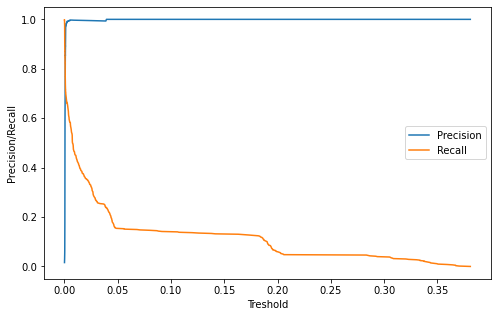

In [37]:
# threshold - 분류 기준을 의미 , Recall(재현율) 실제 positive인 것 중 올바르게 positive를 맞춘 비율 
# Precision(정밀도)는 positive로 예측한 경우 중 올바르게 positive를 맞춘 비율
error_df = pd.DataFrame({'Reconstruction_error': valid_mse,
                        'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'],error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Treshold');plt.ylabel('Precision/Recall')
plt.legend()